# Introduction
In Part I, we collected the data for our project and in Part II we gave ARIMA a try.

In this Part, we will follow the steps the authors took for their analysis. More specifically:
1. Import libraries for preprocessing data
2. Preprocess data using signal processing techniques
3. Visualize and compare the preprocessed data with original
4. Export the preprocessed data for deep learning

### Step 1: Import libraries
We will be using signal processing library PyWavelets (<a href="https://pywavelets.readthedocs.io/en/latest/index.html">documentation</a>) on top of the usual libraries. Make sure you pip install it if you don't have them.
- pywt
- pandas as pd
- numpy as np
- matplotlib.pyplot as plt
- mean_squared_error from sklearn.metrics

In [ ]:
# Step 1: Import libraries

In [2]:
import pywt 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

### Step 2: Read CSV from Part I as DataFrame
Although we transformed the data in Part II for ARIMA, we'll go back to using our original data from Part I.

Read the CSV into a DataFrame. 

Don't forget to set the date as the index, and parse the dates as well so that the index becomes a DateTimeIndex object.

Make sure you have:
- 4,904 rows
- 6 columns

In [ ]:
# Step 2: Read the CSV as a DataFrame

In [11]:
sp500=pd.read_csv("sp500_final.csv",index_col='Date',parse_dates=True)

In [12]:
sp500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000
...,...,...,...,...,...,...
2019-06-25,2945.780029,2946.520020,2916.010010,2917.379883,2917.379883,3578050000
2019-06-26,2926.070068,2932.590088,2912.989990,2913.780029,2913.780029,3478130000
2019-06-27,2919.659912,2929.300049,2918.570068,2924.919922,2924.919922,3122920000


## Data preparation
In this part, we will prepare our data according to the publication.

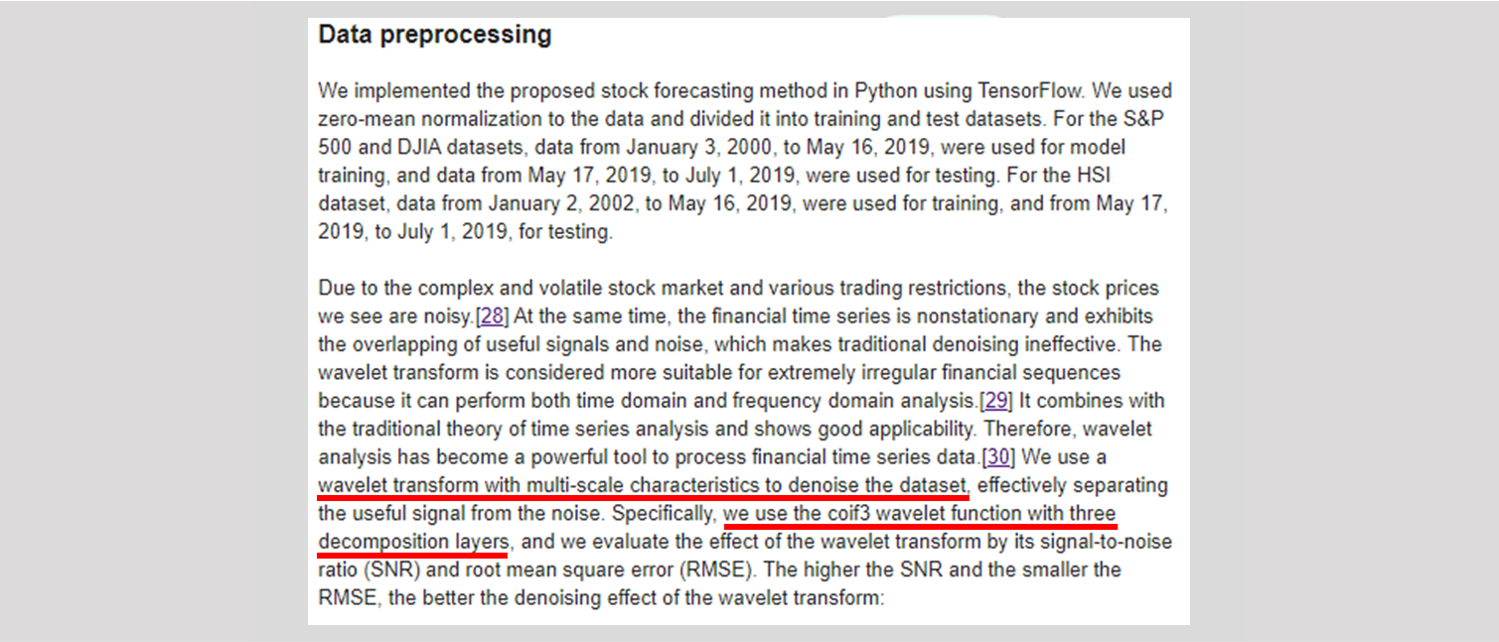

We don't need to perform zero-mean normalization yet, nor split the data so we go straight to the bottom part which is to denoise using wavelet transform.

We usually use wavelet transforms in signal processing, but the authors opted to use it here because of its use in time-series data. 

Fun fact: we had to reverse engineer a lot of things in this research paper because the authors did not publish their code. Don't worry, we're good at this so rest assured. 

<font color = 'red'>Warning: this part isn't easy and don't be shy in using our hints in this Part if you're stuck. Or you can head on to our <a href = "https://bit.ly/UpLevelSG">Telegram group</a> to ask questions.</font>

### Step 3: Define a low-pass filter
We'll have to implement a low-pass filter for 'Open' dataset. 

If you're not used to signal processing in Python, don't worry we got you. 

Basically, you'll have to go to two places to read up:
- <a href='https://pywavelets.readthedocs.io/en/latest/regression/multilevel.html'>PyWavelets documentation for multilevel deconstruction and reconstruction</a>
- You'll have to find the right code snippet in a handy <a href="https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/">guide</a> we found (big thanks Ahmet).

<details>
    <summary><font color = 'green'>SPOILERS! Click once for a look if the guide is no longer available</font></summary>
    <div>
        <img src = 'https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/LowPassFilterFunction.png'>
    </div>
</details>

In [ ]:
# Step 3: Define a low-pass filter

In [13]:
def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[3:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[3:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

### Step 4: Edit the low-pass filter function a bit
If you copied the function verbatim from the guide, you're halfway there! We just need to edit the function a little bit. 

The function starts with editing the 2nd level of the deconstructed signal onwards, with the threshold. <strong>However, we want to preserve the first three levels instead, i.e. edit the layers from 4th level onwards.</strong>

Edit the function slightly so that we do that. The answer to identifying the levels lies in the documentation.

<details>
    <summary><font color = 'green'>Click once if you're paranoid and want to be exactly sure what you need to change</font></summary>
    <div>
        <strong>Just change the two coeff[1:] to coeff[3:]</strong>
    </div>
</details>

### Step 5: Generate a filtered version of 'Open'
Now that you've your modified function, let's generated a filtered version of 'Open' values.

We'll be passing through the column values from 'Open', along with a thresh value of 0.01, and a wavelet of 'coif3'.

In [ ]:
# Step 5: Generate the filtered version of 'Open'

In [14]:
open=sp500['Open']

filtered_open = lowpassfilter(open, 0.01,'coif3')

In [15]:
filtered_open

array([1509.89111291, 1460.42307784, 1438.65851606, ..., 2913.6476927 ,
       2877.86069852, 2924.41629984])

### Step 6: Add a new column 'FilteredOpen'
Add a new column named 'FilteredOpen' containing the filtered values.

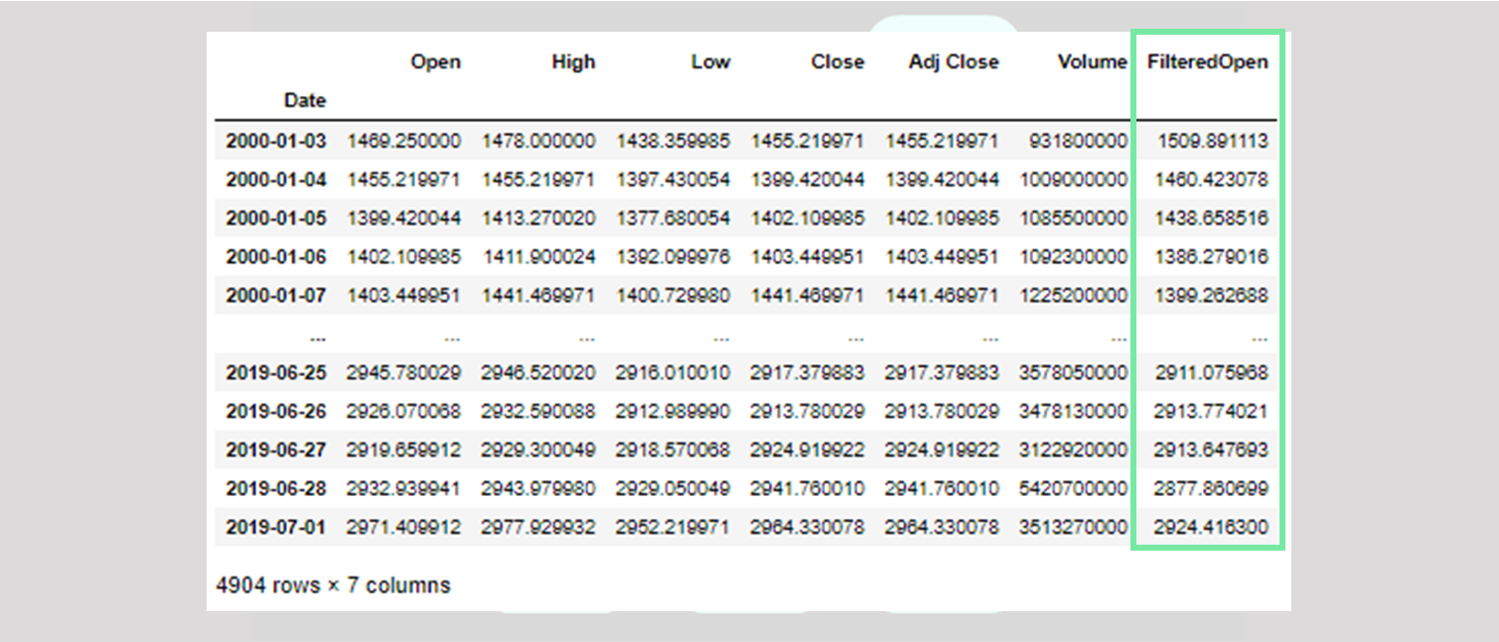

In [ ]:
# Step 6: Add the FilteredOpen column

In [16]:
sp500['FilteredOpen']=filtered_open

In [17]:
sp500

,Open,High,Low,Close,Adj Close,Volume,FilteredOpen
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,1509.891113
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1460.423078
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1438.658516
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1386.279016
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1399.262688
...,...,...,...,...,...,...,...
2019-06-25,2945.780029,2946.520020,2916.010010,2917.379883,2917.379883,3578050000,2911.075968
2019-06-26,2926.070068,2932.590088,2912.989990,2913.780029,2913.780029,3478130000,2913.774021
2019-06-27,2919.659912,2929.300049,2918.570068,2924.919922,2924.919922,3122920000,2913.647693


### Step 7: Plot FilteredOpen
Plot FilteredOpen on a graph. Optionally, plot it over the original 'Open' as well. 

Does the resulting FilteredOpen plot look similar to the denoised Open on Fig 6 in the publication?

In [ ]:
# Step 7: Plot FilteredOpen

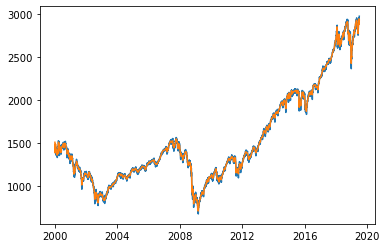

In [19]:
plt.plot(sp500['Open'])
plt.plot(sp500['FilteredOpen'])

<details>
    <summary>Does it?</summary>
    <div>
        <strong>Yes the resemblance is uncanny.</strong>
    </div>
</details>

### Step 8: Calculate the RMSE 
Let's do one last thing - calculate the RMSE between 'Open' and 'FilteredOpen'.

Use the mean_squared_error function, and square root it. 

With reference to Table 2 in the publication, does the resulting RMSE match Coif3's value of 13.99?

In [ ]:
# Step 8: Calculate the RMSE

In [26]:
mse_value=mean_squared_error(sp500['Open'],sp500['FilteredOpen'])
mse_value**0.5

13.978930913070931

<details>
    <summary>Does the RMSE match the publication?</summary>
    <div>
        <strong>Yes, we should get 13.978930913070924 from our own calculation!</strong>
    </div>
</details>

### [Optional] Try other wavelets
If you're curious, go ahead and try the other three wavelets that the authors used - sym3, db5, and haar.

Those are classic wavelets used in signal processing as well. One note of caution, we were not able to replicate completely the RMSE values so please don't be alarmed if the RMSE values are not exact.

In [ ]:
# Optional: Try other wavelets

### Step 9: Export the DataFrame to CSV
Now that we're done with processing the data, let's export the DataFrame containing 'FilteredOpen' as a CSV.

In [ ]:
# Step 9: Export the DataFrame as CSV

In [27]:
sp500.to_csv(r'sp500_Filtered_open.csv')

## Preparing for Colab
### [Optional] Setting up Google Colab
If you've never used Google Colab before, just think of it as Jupyter notebooks on the cloud. 

You can collaborate with other data scientists with Google Colab directly - think Google Docs but for codewriting. 

If this is the first time you're working with Google Colab, you'll need to add it into your Drive.

![GoogleColabSetupPartI](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectTeaFermentation/GoogleColabSetupPartI.png)

1. Click on "Add" on the upper left corner
2. Hover over "More"
3. Click on "Connect more apps"
4. At the popup, search for "Colaboratory"
5. Click on the option that appears

![GoogleColabSetupPartII](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectTeaFermentation/GoogleColabSetupPartII.png)

1. Click on 'Install'
2. Click on 'Confirm'

And you're all done. You can now upload ipynb files into your Drive and read it into Google Colab.

### Step 10: Upload Part IV and the CSV 
Part IV will be done on Google Colab, so we'll need to upload the files into your Google Drive. 

Create a folder on Google Drive, give it any name you'd like (we named ours Project Finance x LSTM).

In the new folder, upload:
1. Project Finance x LSTM (Part IV)
2. The CSV that you got from Step 9 (we named it CSVFromStep9.csv)

This is how your Google Drive should look like:

```
Google Drive folder (Project Finance x LSTM)
│   Project Finance x LSTM (Part IV).ipynb
│   CSVFromStep9.csv

```
It's a relatively simple and straightforward folder structure so this is what you'll see:

![GoogleDriveFolder](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/GoogleDriveFolder.png)

### End of Part III
Okay, you're all set to work on the next Part which takes place of <font color='orange'>Google Colab</font>. 

In the next Part, we will train an LSTM model to predict stock pricing for S&P 500. 